In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle
import gzip
from matplotlib import rc
from matplotlib.lines import Line2D
import warnings

rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

Simulating radial isochron map

In [181]:
def simulating_radial_isochron_map(theta_start, antal_iterationer, Omega, A_ext):
   
    theta = [theta_start]
    iterationer = np.arange(antal_iterationer + 1)
    
    for i in range(antal_iterationer):
        try:
            indmad = (np.cos(theta[i])+A_ext) / (np.sqrt(1 + (2*A_ext*np.cos(theta[i])) + A_ext**2))
            theta_next = np.arccos(indmad) + 2*np.pi*Omega
            theta.append(theta_next)
        except ValueError:
            print("FEJL")
            theta.append(np.nan)
    return np.array(iterationer), np.array(theta)

In [201]:
sim = simulating_radial_isochron_map(0, 100, 2.3, 5)
print(sim[1][-1] / (2*np.pi*100) / (100))
print(sim)

0.00023304586551906904
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100]), array([ 0.        , 14.45132621, 14.65135634, 14.64211348, 14.64274318,
       14.64270092, 14.64270376, 14.64270357, 14.64270358, 14.64270358,
       14.64270358, 14.64270358, 14.64270358, 14.64270358, 14.64270358,
       14.64270358, 14.64270358, 14.64270358, 14.64270358, 14.64270358,
       14.64270358, 14.64270358, 14.64270358, 14.64270358, 14.64270358,
       14.64270358, 14.64270358, 14.64270358, 14.6427

In [176]:
def entrainment_radial(omega_list, coupling_list):
    radial_dict = {"Omega": [], "coupling_strength": [], "entrainment_value": [], "exception": []}
    A_int = 1
    A_ext_list = coupling_list * A_int

    for i in tqdm(range(len(omega_list)), desc="Processing"):
        for j in range(len(A_ext_list)):
            antal_iterationer = 400 #svarer til antallet af peaks
            theta_start = 0
            simulation_radial = simulating_radial_isochron_map(theta_start, antal_iterationer, omega_list[i], A_ext_list[j])
            sim_iterationer, sim_theta = simulation_radial[0], simulation_radial[1]

            rotation_number = 0
            exception = False
            
            try:
                rotation_number = sim_theta[-1] / (2*np.pi ) / (antal_iterationer)
            except:
                exception = True
            
            radial_dict["Omega"].append(omega_list[i])
            radial_dict["coupling_strength"].append(coupling_list[j])
            radial_dict["entrainment_value"].append(rotation_number)
            radial_dict["exception"].append(exception)
        
    return radial_dict

In [184]:
antal_omega = 100
antal_coupling = 100

# Der laves gridsearch på disse omega og coupling
omega_list = np.linspace(0,5,antal_omega)
coupling_list = np.linspace(0,2,antal_coupling)

entrainment_sim = entrainment_radial(omega_list, coupling_list)

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/sh/2tb9lygj0hd_5707cy_mb_gc0000gn/T/ipykernel_21631/2179096293.py:9: RuntimeWarning: invalid value encountered in arccos
  theta_next = np.arccos(indmad) + 2*np.pi*Omega
Processing: 100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


In [190]:
Omegas_tested = entrainment_sim["Omega"]
Coupling_strengths_tested = entrainment_sim["coupling_strength"]
Entrainments = np.array(entrainment_sim["entrainment_value"])
Exceptions = entrainment_sim["exception"]

threshold = 0.01
tunger = [0, 0.5, 1, 1.5, 2, 2.5, 3]
tunger_v2 = np.linspace(0.1,3,30)

colors = ['C0', 'C1', 'C2', 'C6', 'C7', 'C8', 'C9']
colors_v2 = ["red", "orange", "blue", "magenta", "green", "cyan", "darkviolet"]
arnold_color_scheme = ["#548687", "#56445D", "#A26769", "#9CB380", "#508AA8", "#C8EAD3", "#31474D", '#DAE0DC']
label = ["0", fr"$\frac{1}{2}$", "1", fr"$\frac{3}{2}$", "2", fr"$\frac{5}{2}$", "3", fr"$n\cdot0.1$"] 

def get_color_map(Entrainments, tunger, threshold, colors):
    color_map = []

    for entrainment in tqdm(Entrainments, "Processing"):
        # Initialize the color to white (default color)
        color = 'white'

        # Check if entrainment falls within any of the specified ranges
        for i, start in enumerate(tunger_v2):
            if start - threshold <= entrainment <= start + threshold:
                color = '#DAE0DC'
                break  # Break out of the loop once a matching range is found

        # Check if entrainment falls within any of the specified ranges
        for i, start in enumerate(tunger):
            if start - threshold <= entrainment <= start + threshold:
                color = arnold_color_scheme[i]
                break  # Break out of the loop once a matching range is found

        color_map.append(color)

    return color_map

color_map = get_color_map(Entrainments, tunger, threshold, colors)

Processing: 100%|██████████| 10000/10000 [00:00<00:00, 29494.09it/s]


Processing: 0it [00:00, ?it/s]


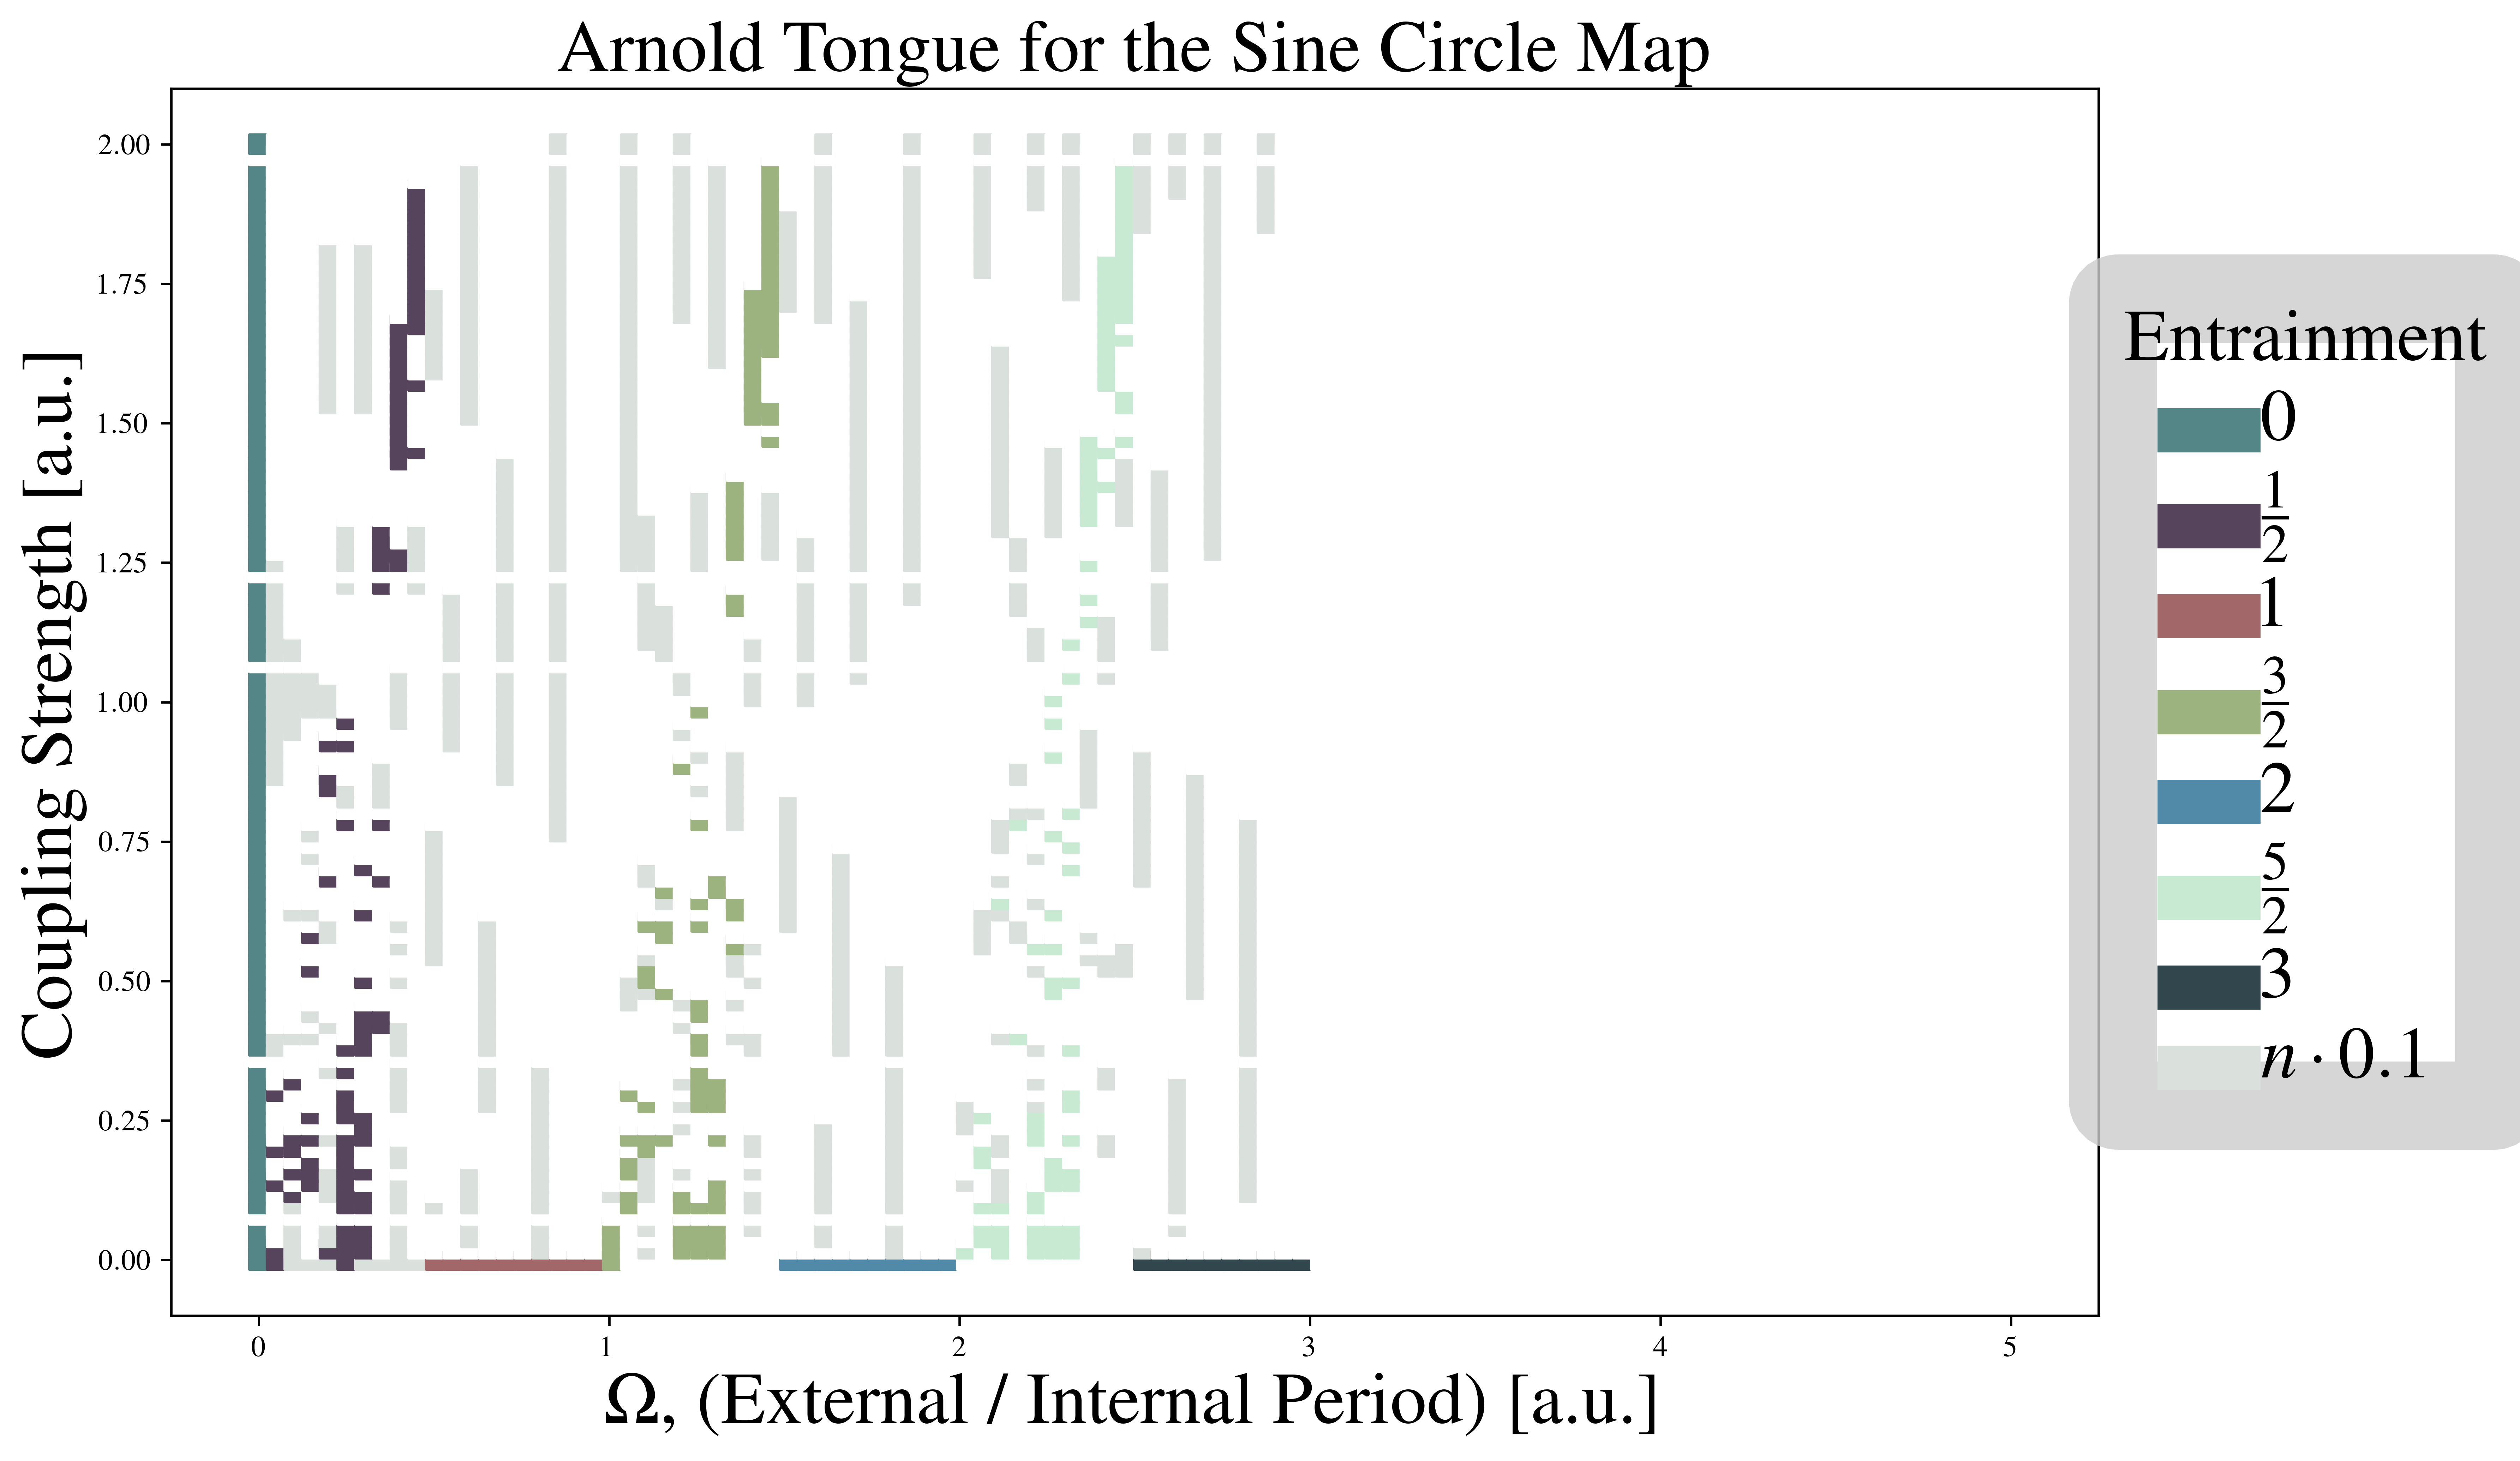

In [191]:
plt.figure(figsize=(11,7), dpi=600)

tqdm(plt.scatter(Omegas_tested, Coupling_strengths_tested, c=color_map, s=40, marker="s"), "Processing")

handles = []
for i in range(len(arnold_color_scheme)):
    line = Line2D([], [], color=arnold_color_scheme[i], lw=15, label=label[i])
    handles.append(line)

plt.title("Arnold Tongue for the Sine Circle Map", fontsize=25)
plt.ylabel("Coupling Strength [a.u.]", fontsize=25)
plt.xlabel(rf"$\Omega$, (External / Internal Period) [a.u.]", fontsize=25)
legend = plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Entrainment')
plt.tight_layout()

legend.legend_handles[0]._sizes = [40]  # Increase marker size for better visibility
legend.get_frame().set_linewidth(30)  # Increase border width
legend.get_title().set_fontsize(25)  # Increase title font size
for text in legend.get_texts():
    text.set_fontsize(25)  # Increase label font size